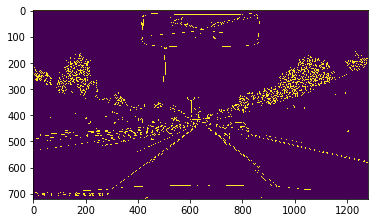

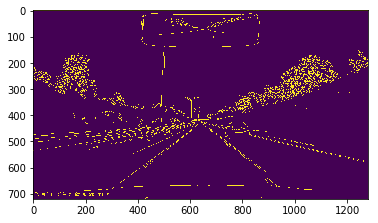

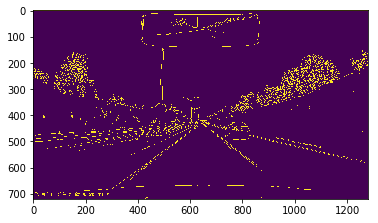

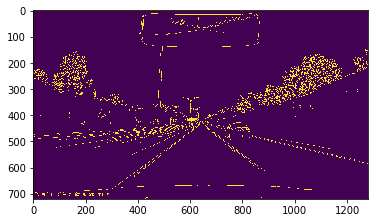

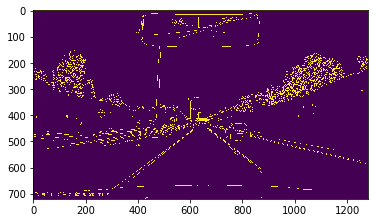

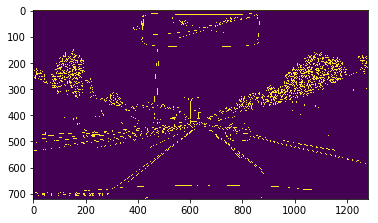

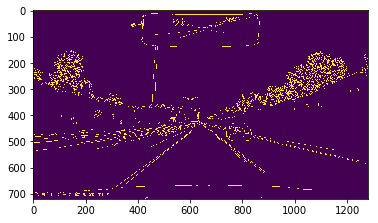

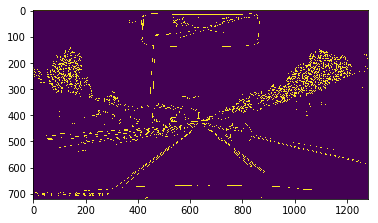

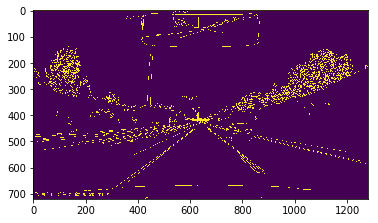

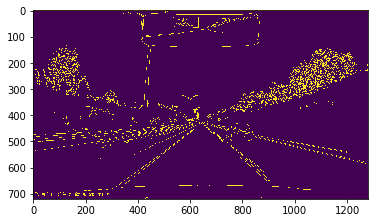

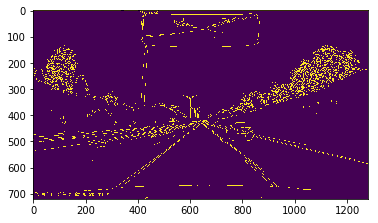

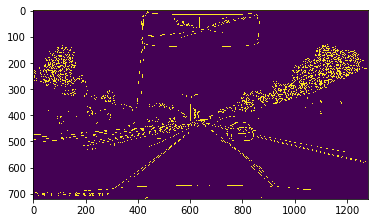

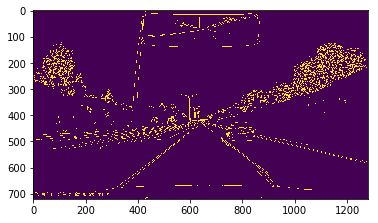

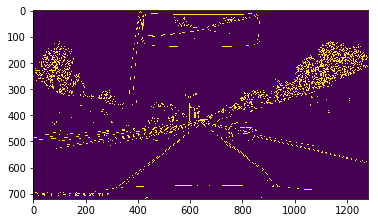

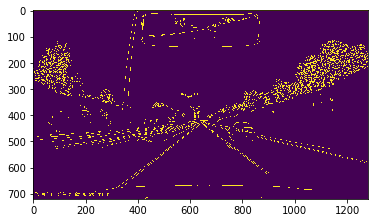

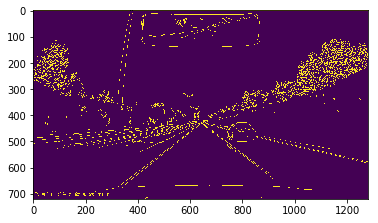

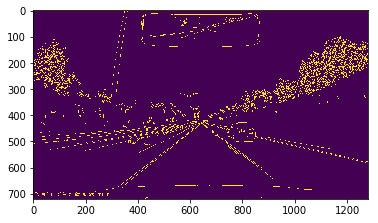

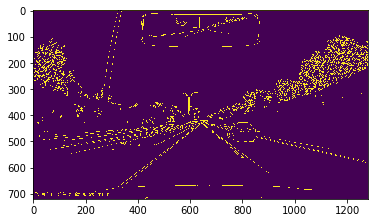

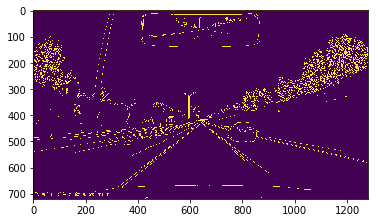

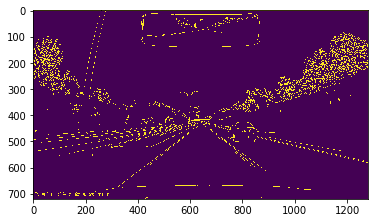

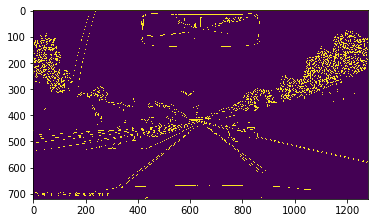

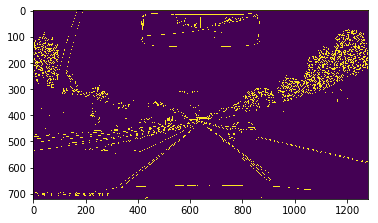

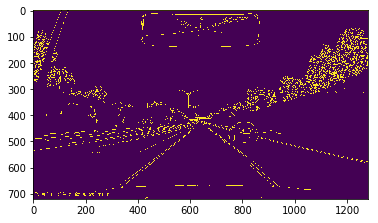

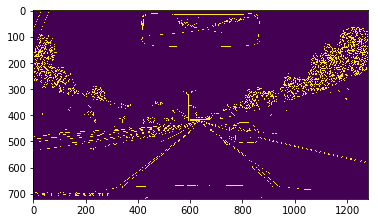

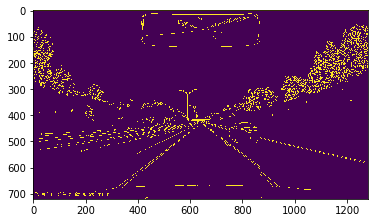

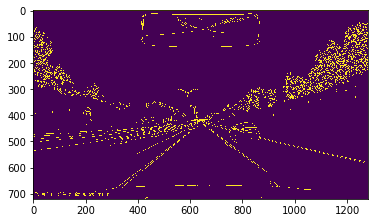

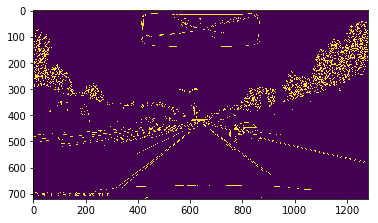

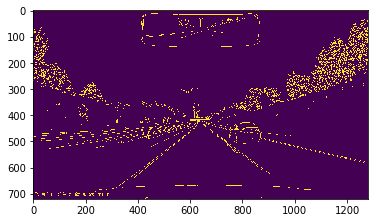

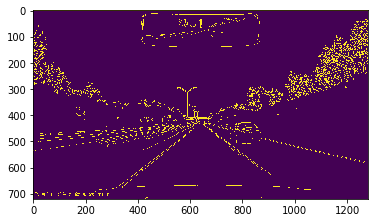

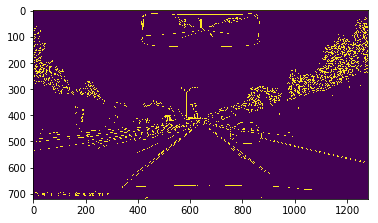

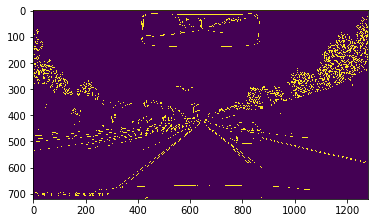

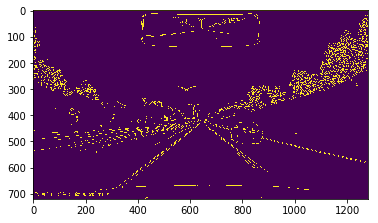

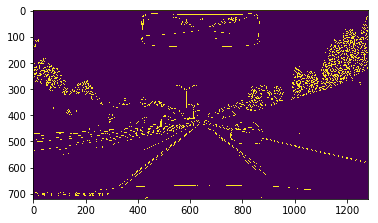

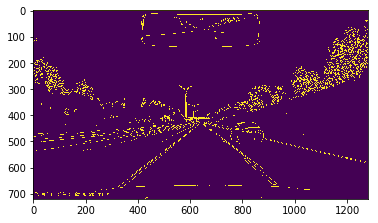

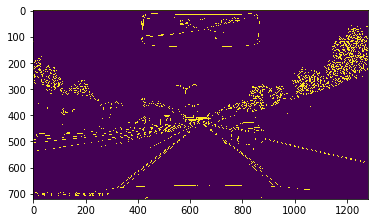

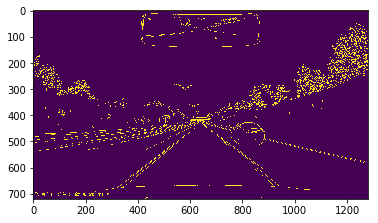

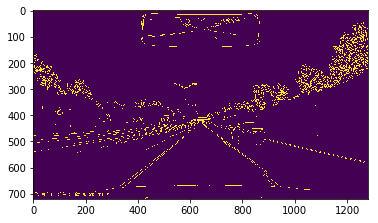

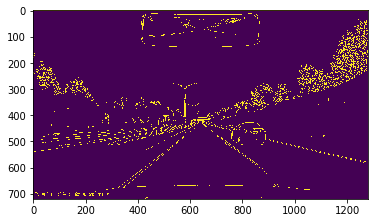

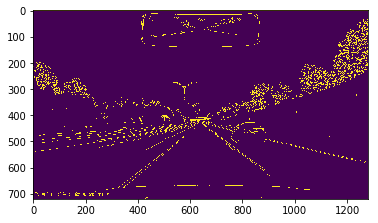

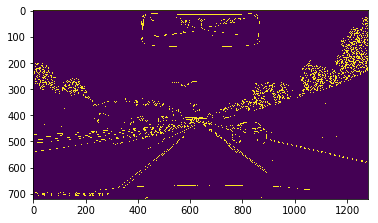

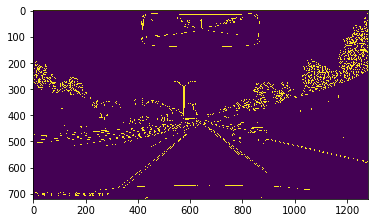

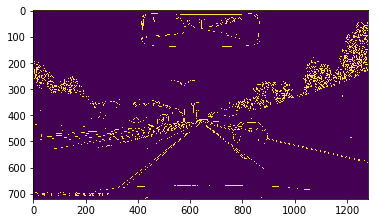

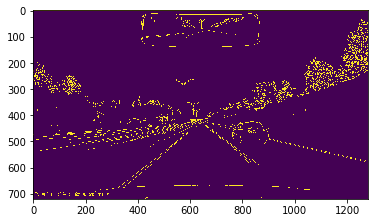

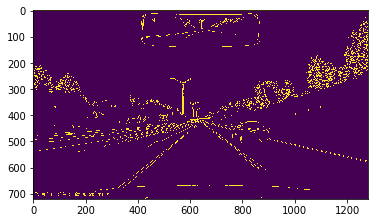

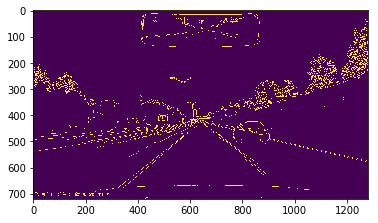

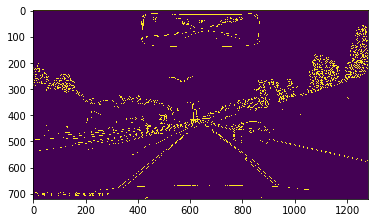

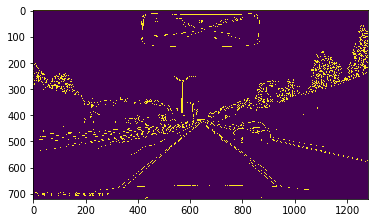

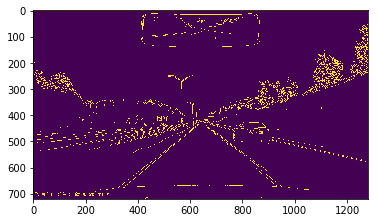

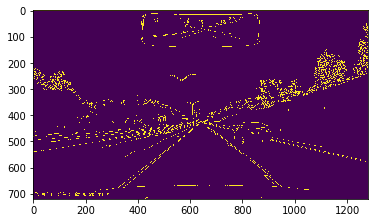

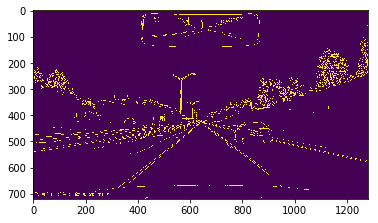

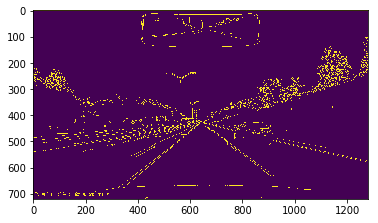

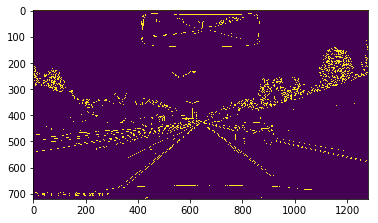

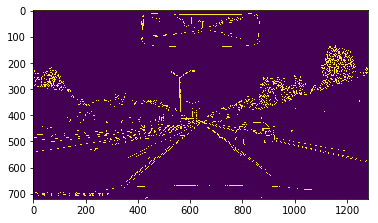

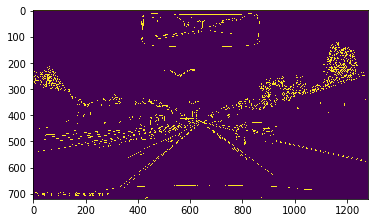

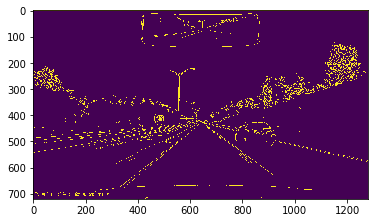

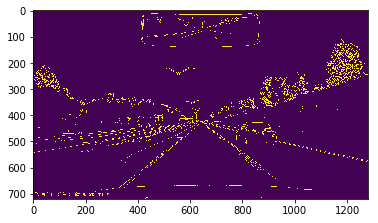

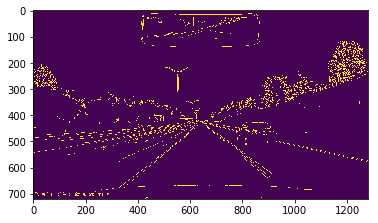

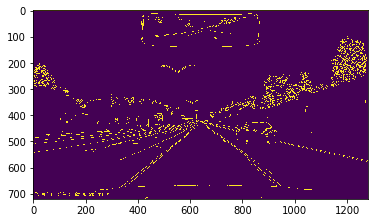

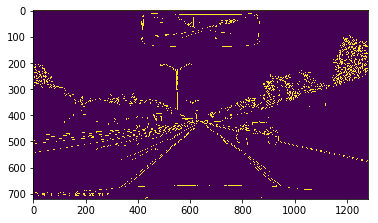

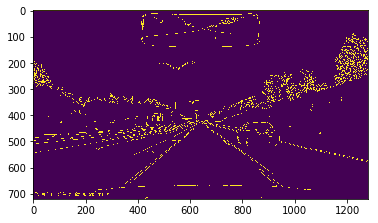

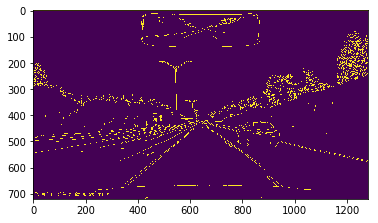

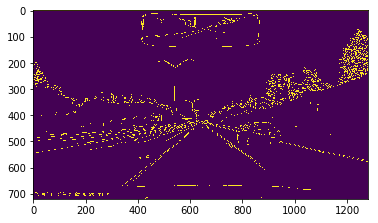

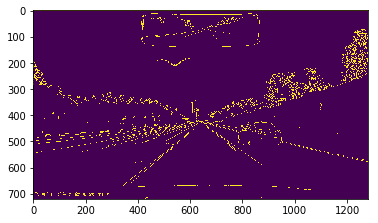

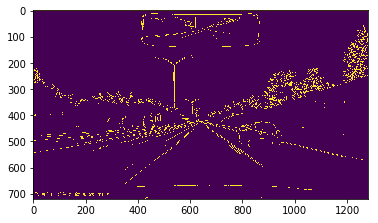

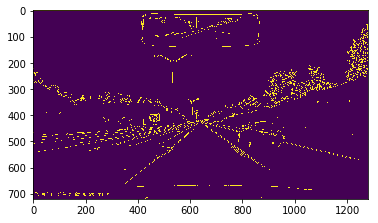

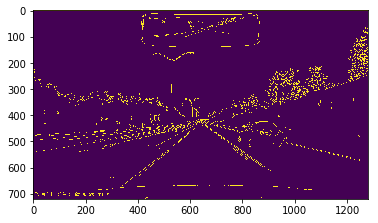

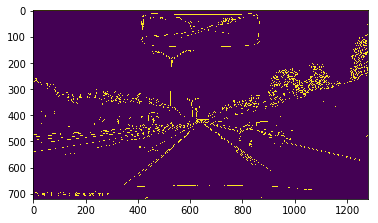

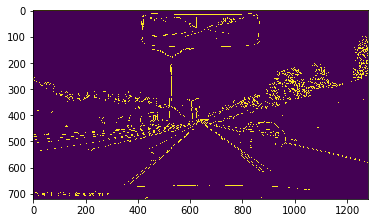

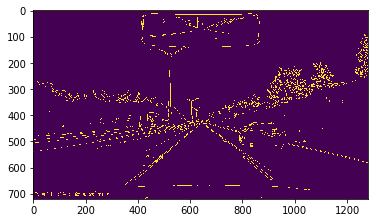

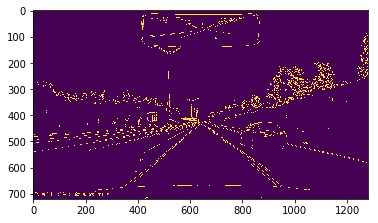

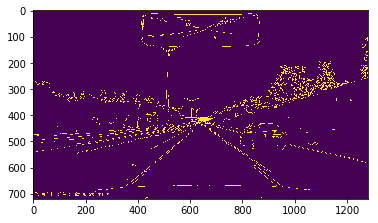

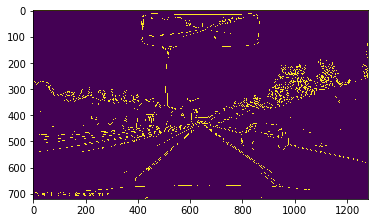

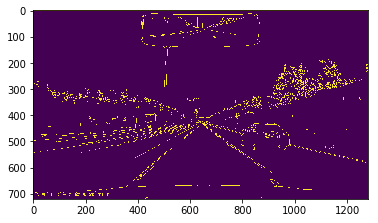

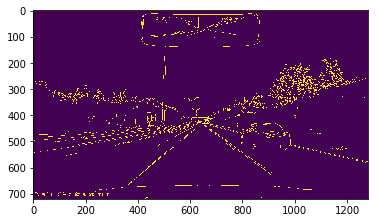

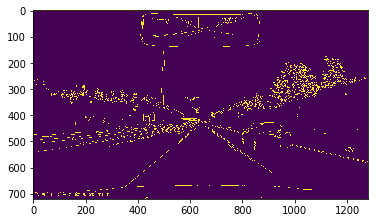

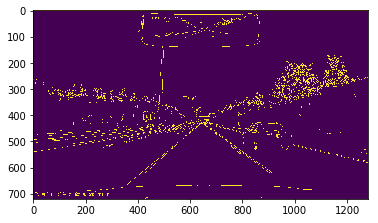

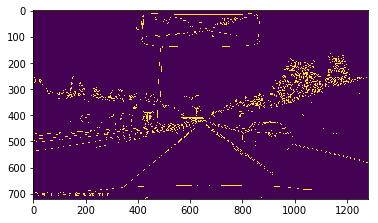

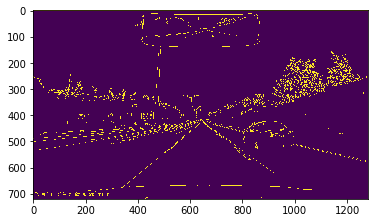

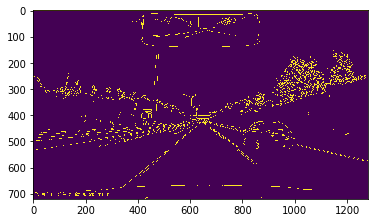

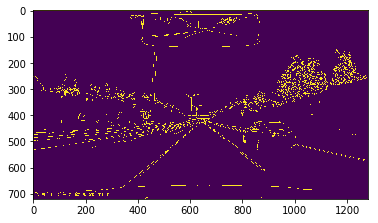

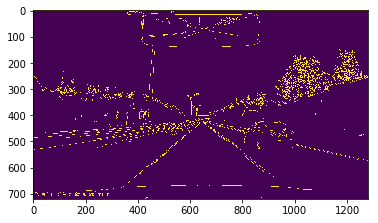

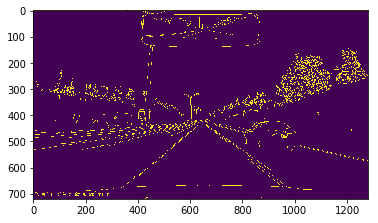

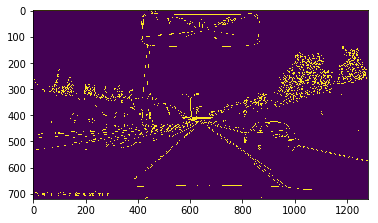

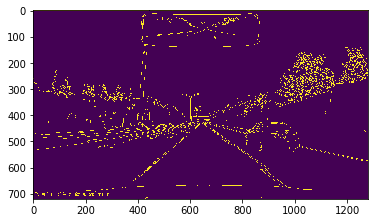

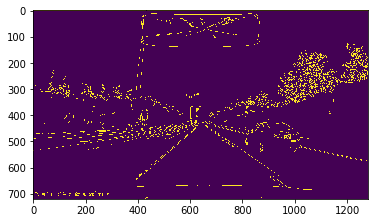

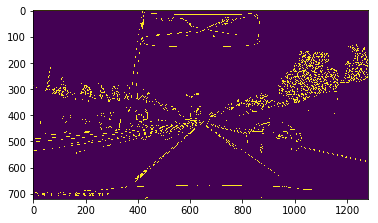

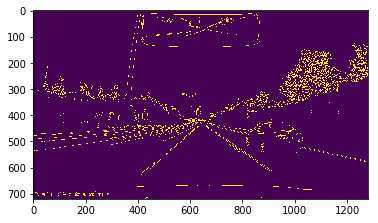

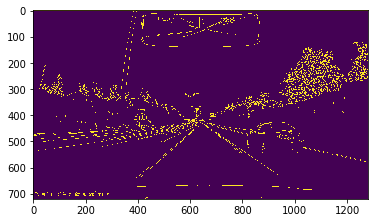

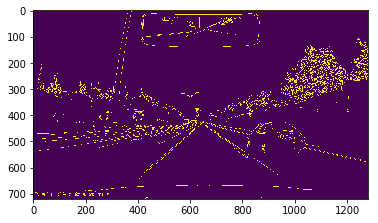

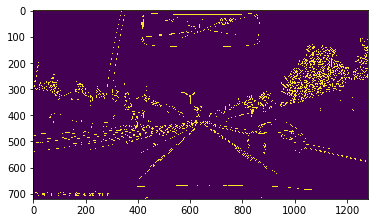

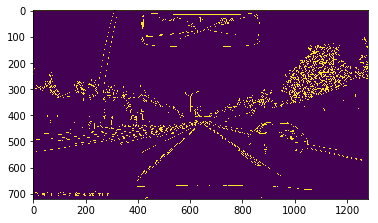

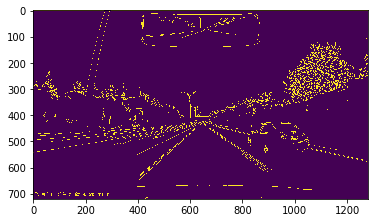

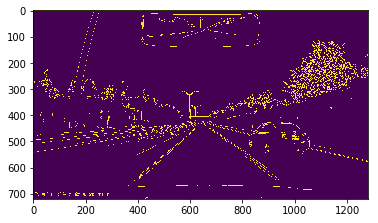

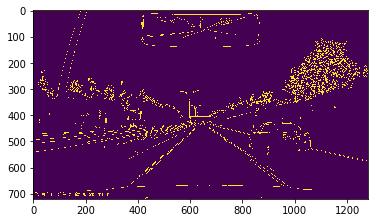

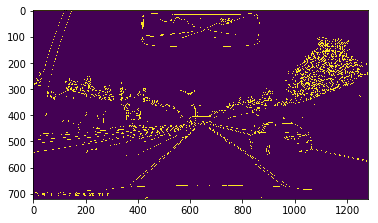

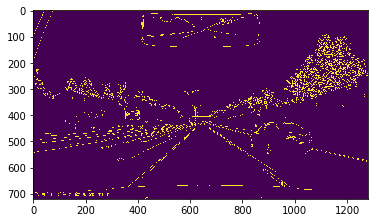

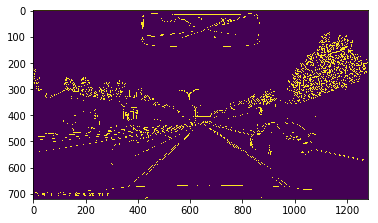

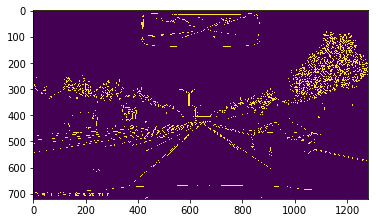

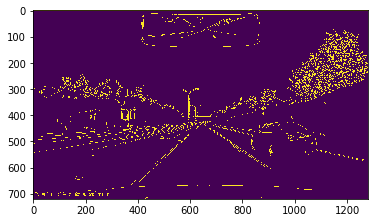

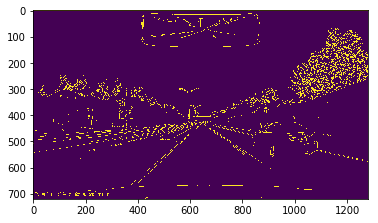

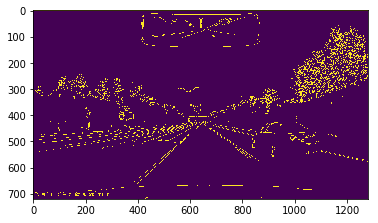

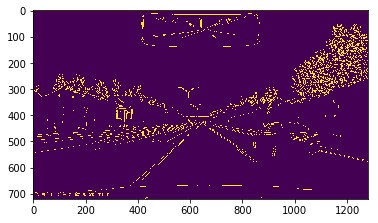

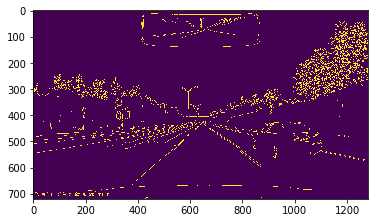

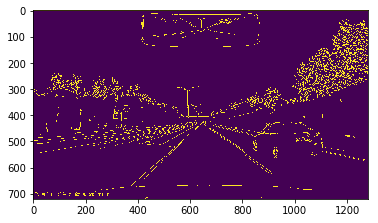

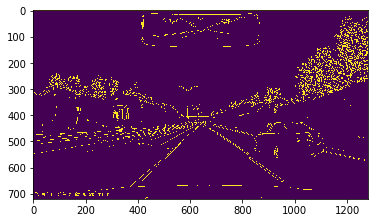

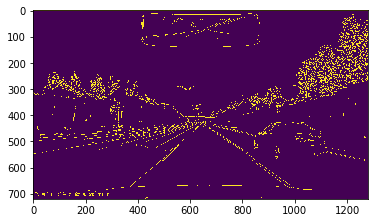

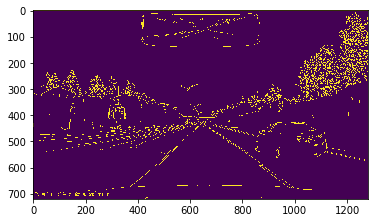

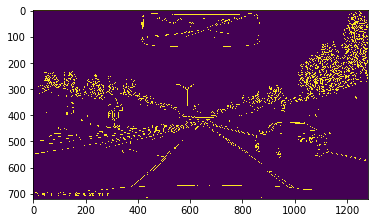

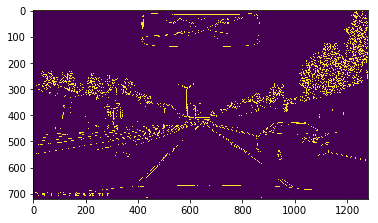

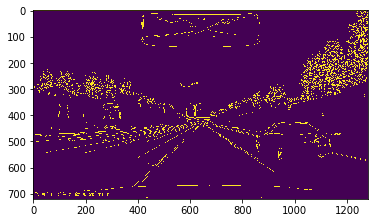

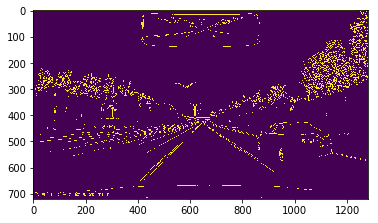

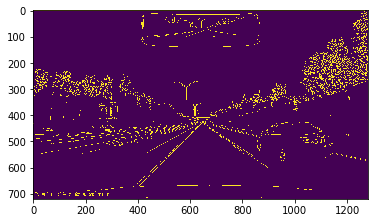

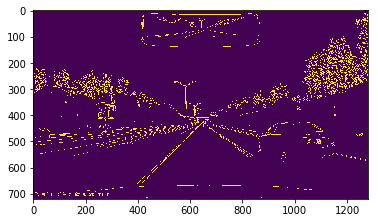

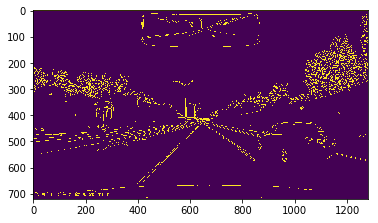

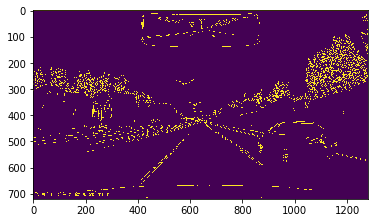

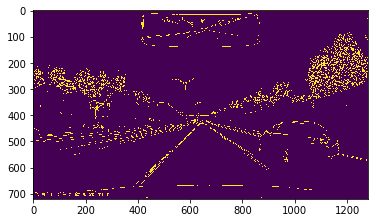

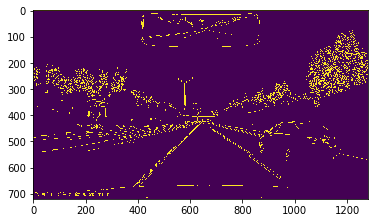

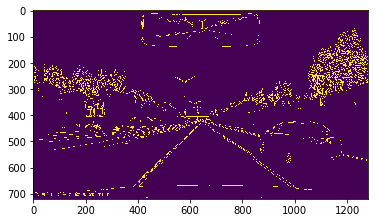

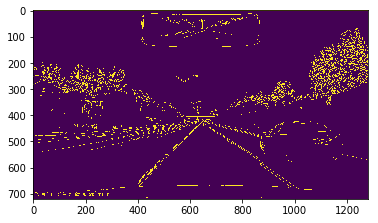

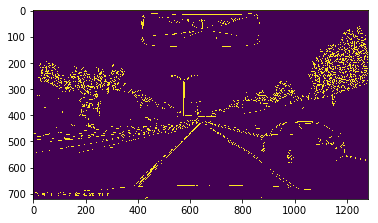

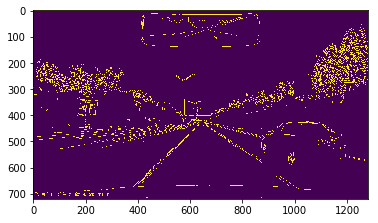

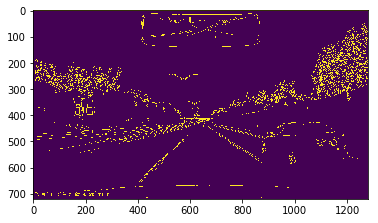

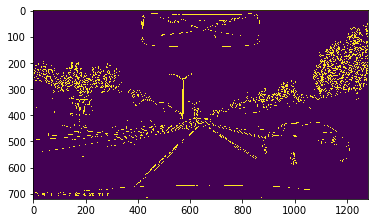

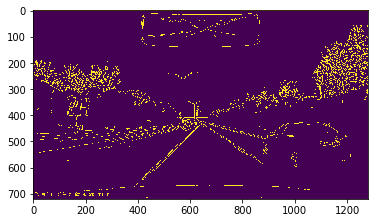

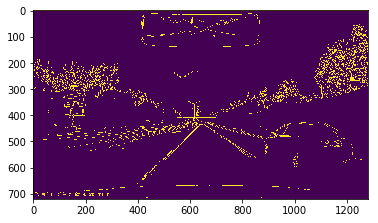

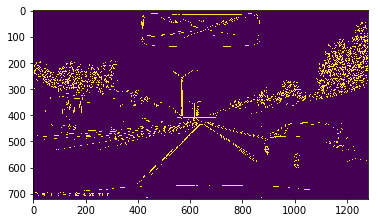

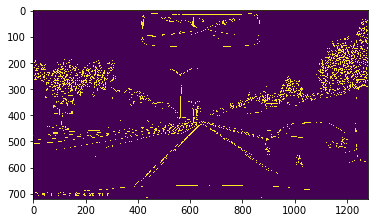

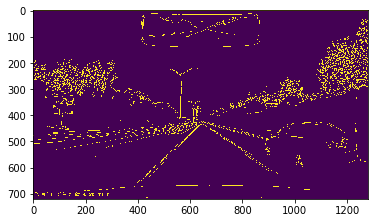

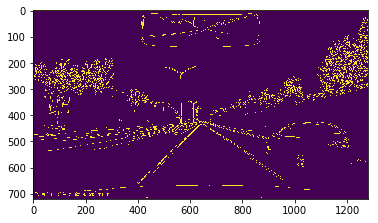

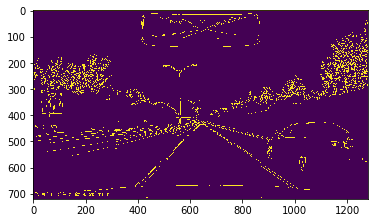

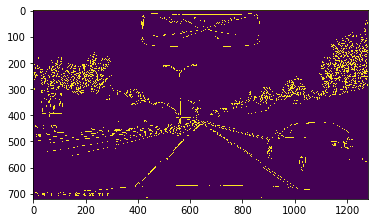

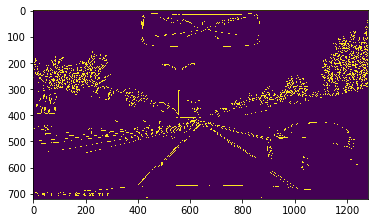

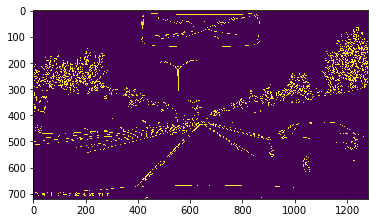

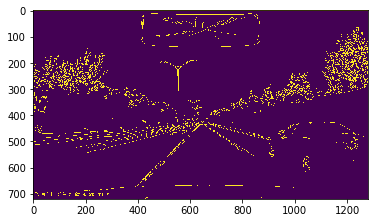

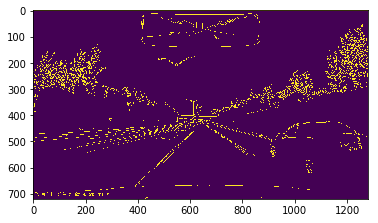

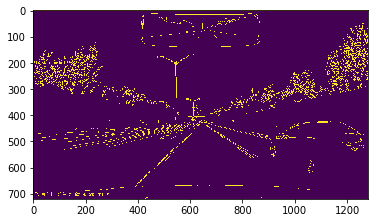

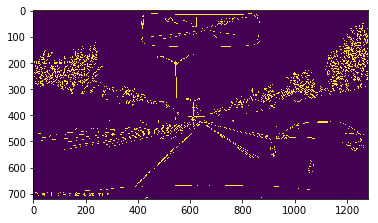

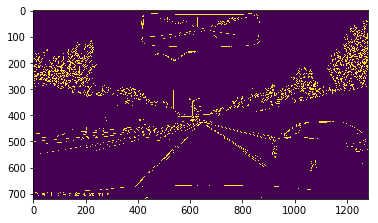

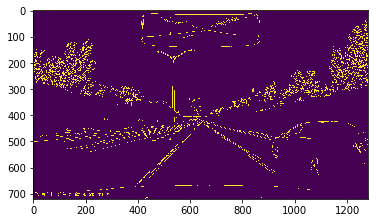

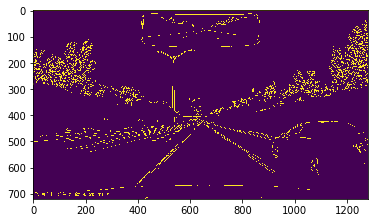

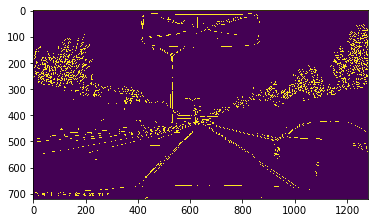

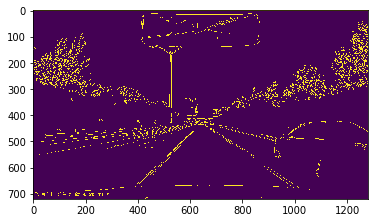

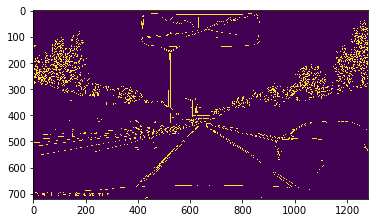

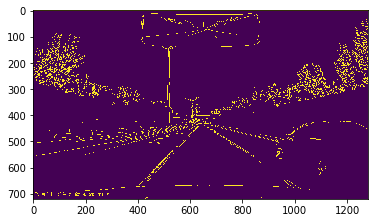

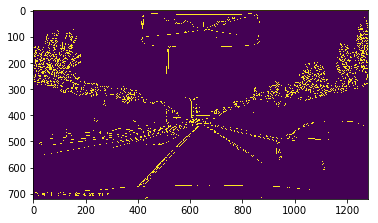

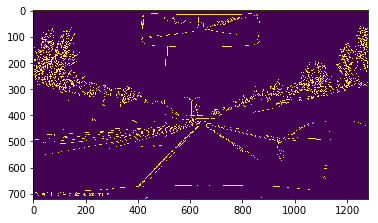

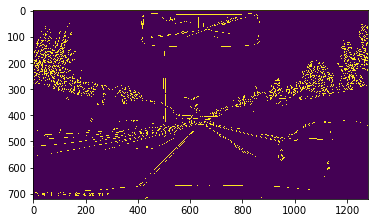

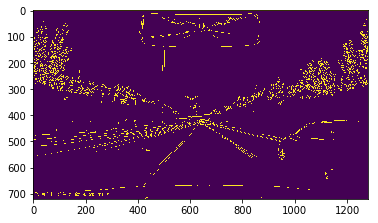

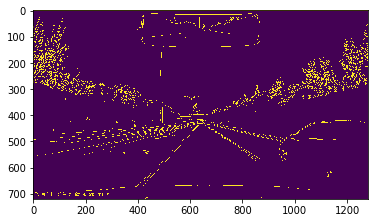

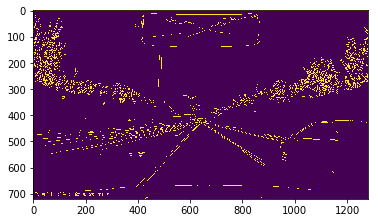

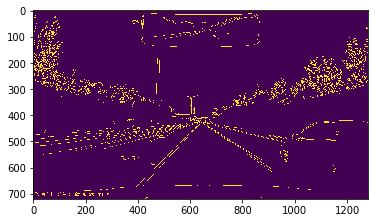

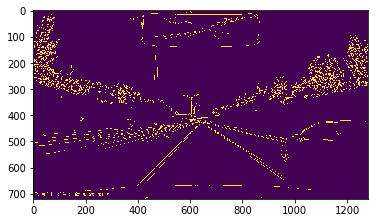

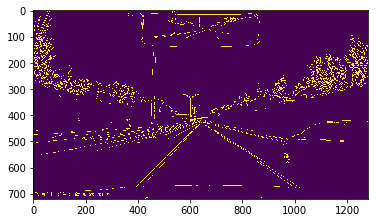

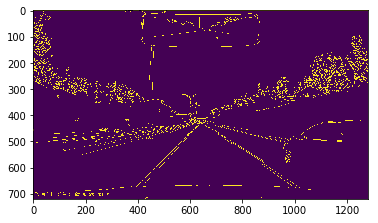

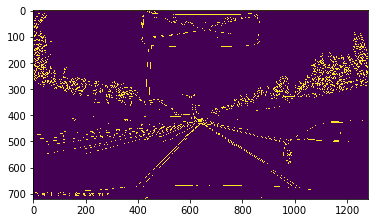

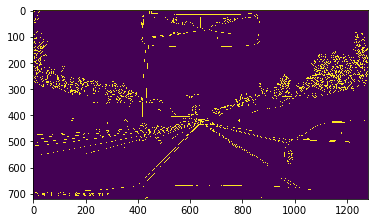

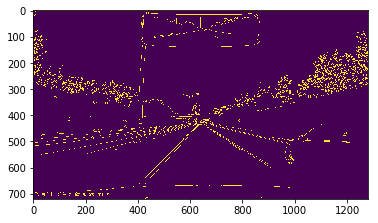

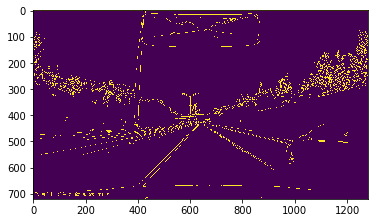

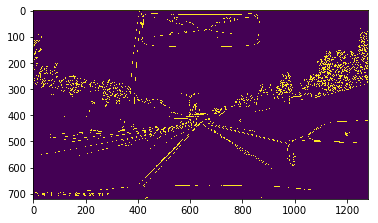

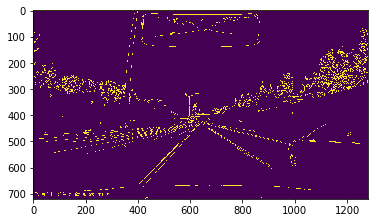

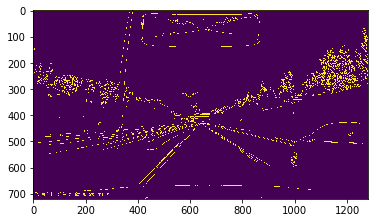

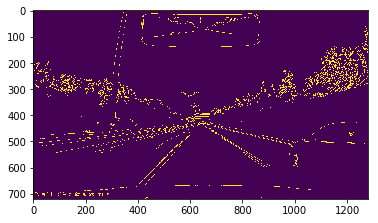

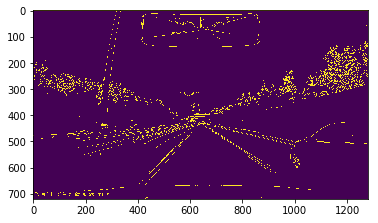

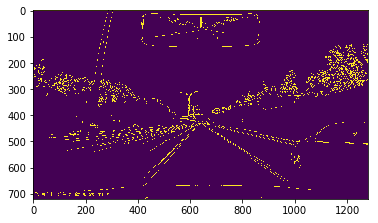

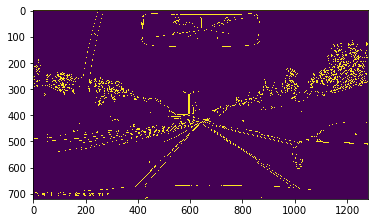

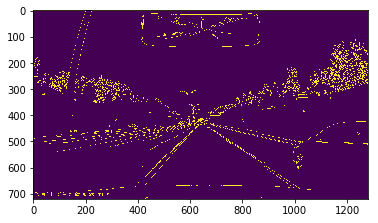

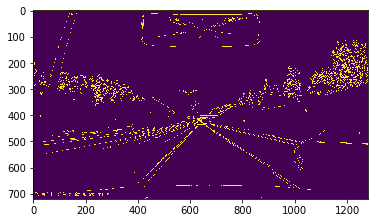

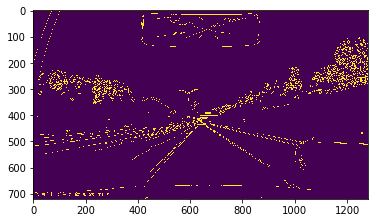

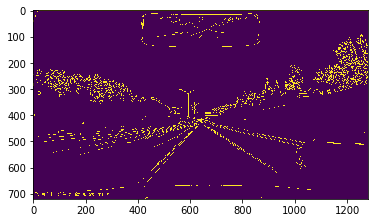

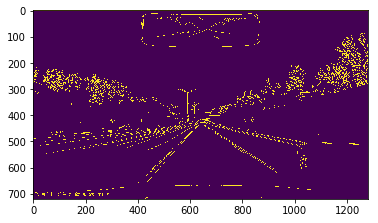

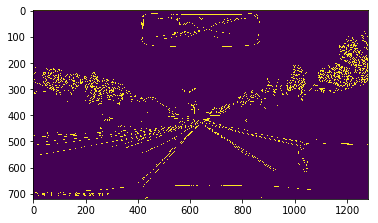

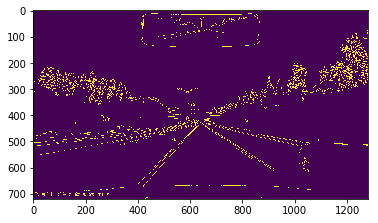

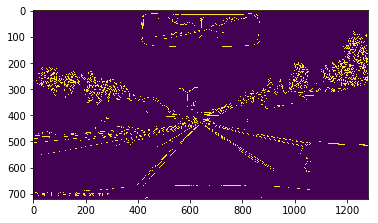

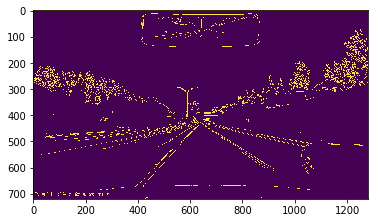

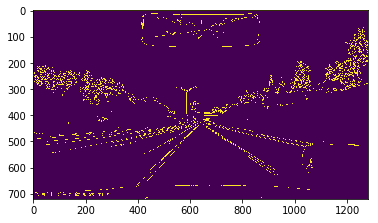

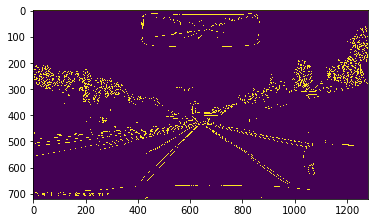

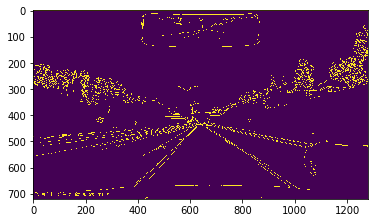

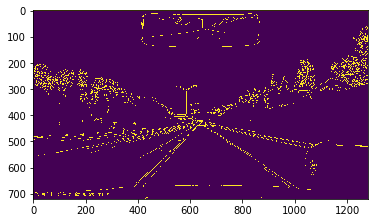

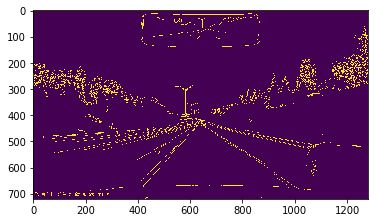

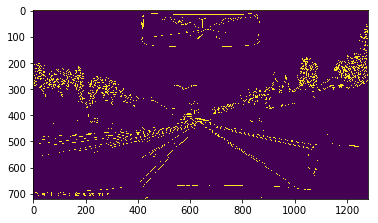

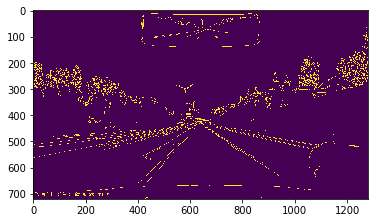

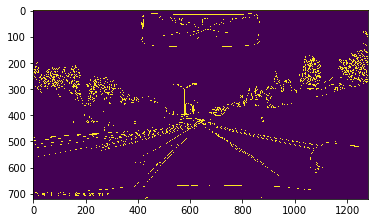

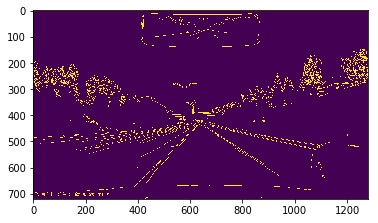

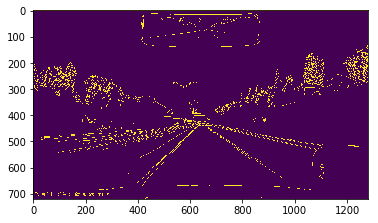

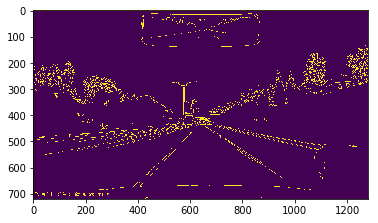

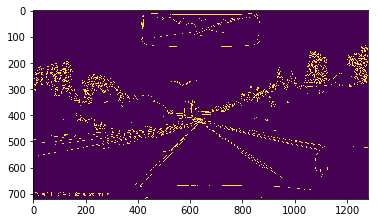

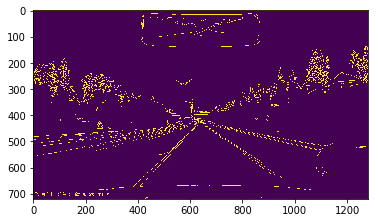

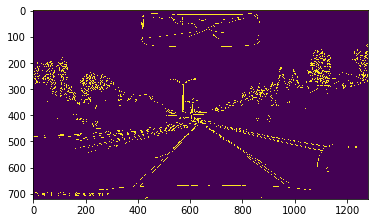

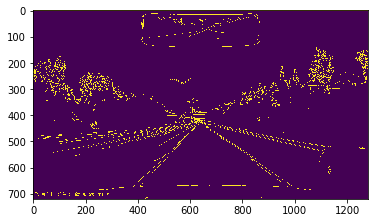

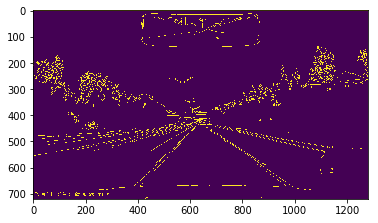

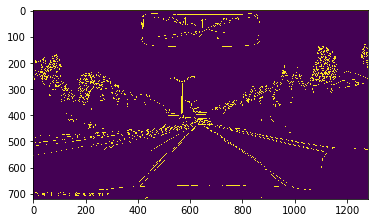

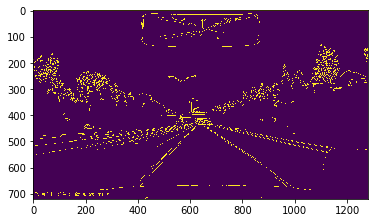

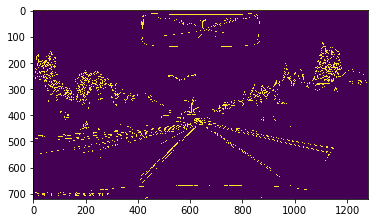

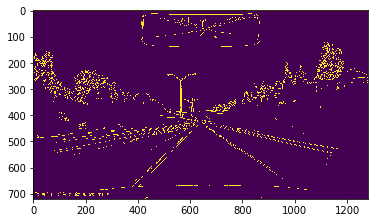

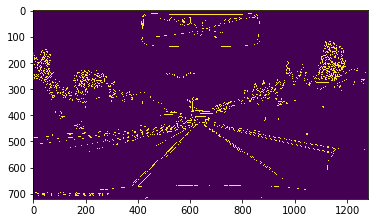

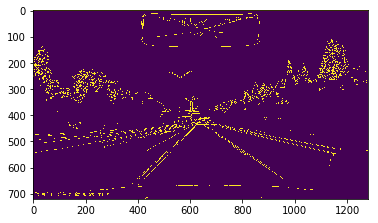

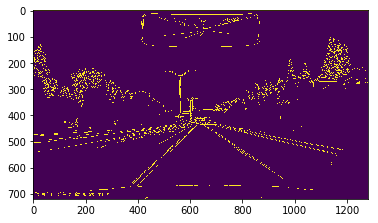

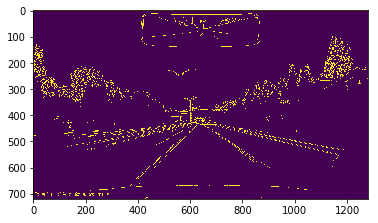

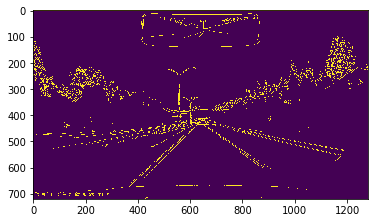

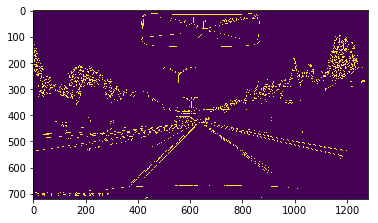

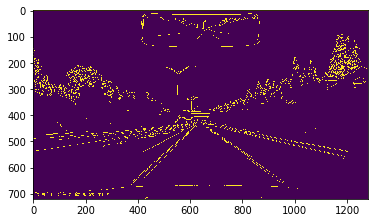

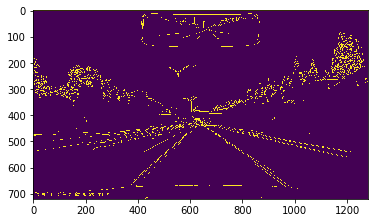

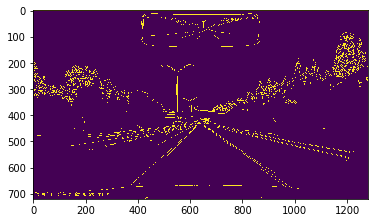

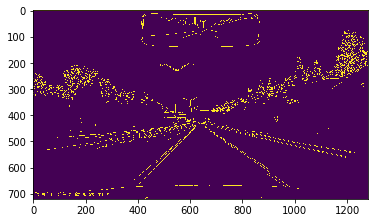

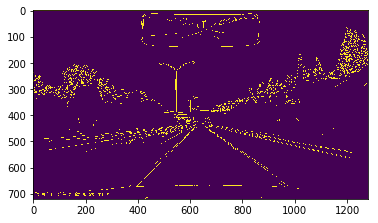

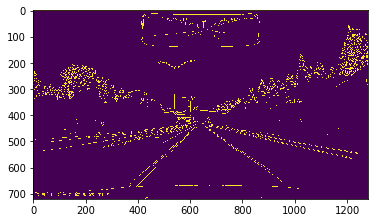

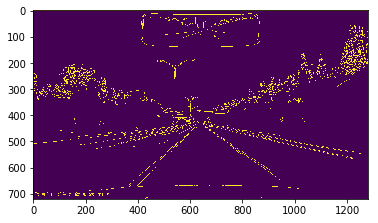

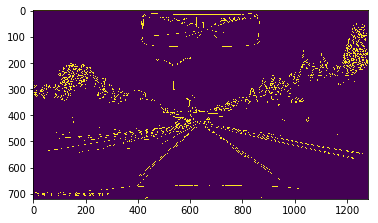

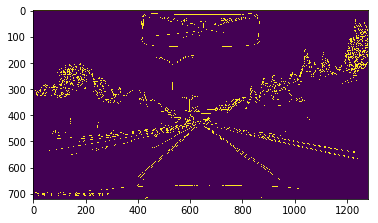

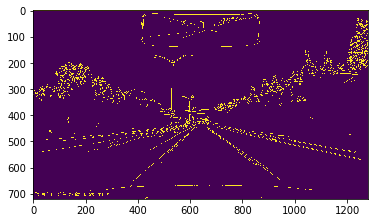

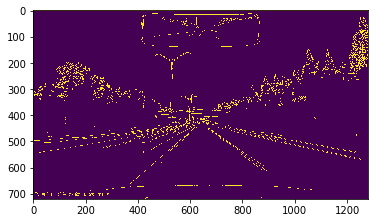

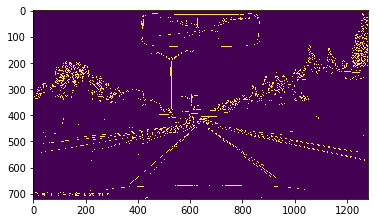

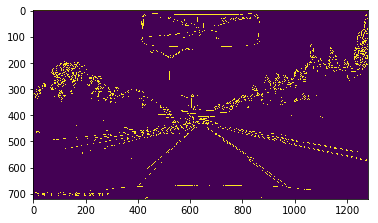

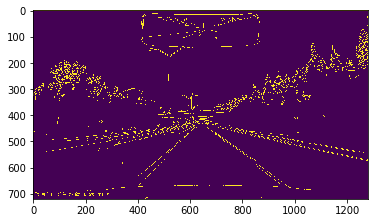

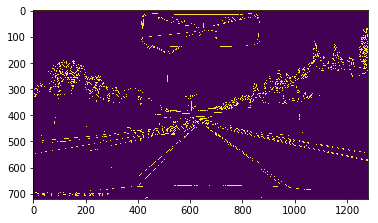

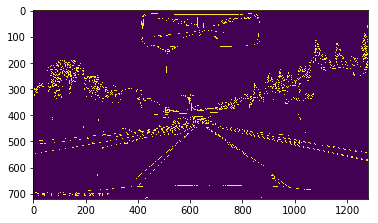

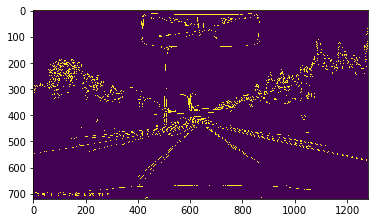

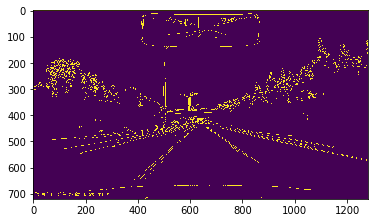

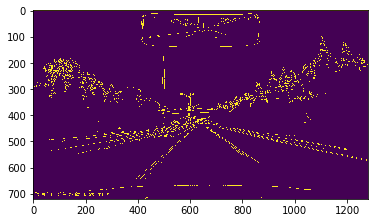

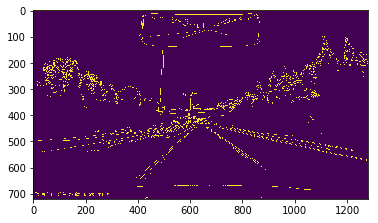

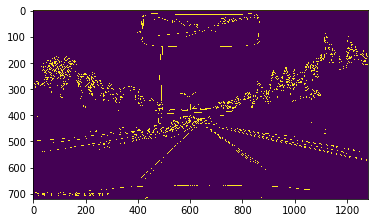

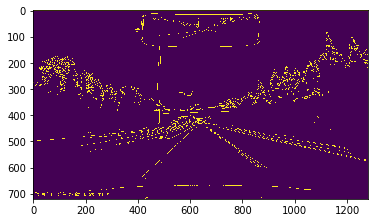

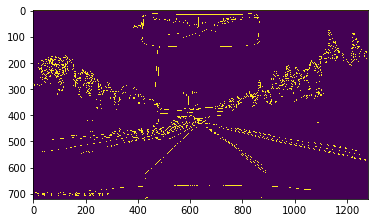

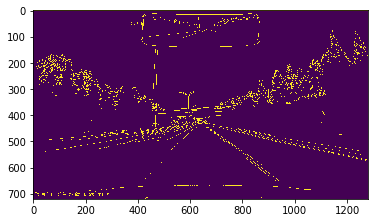

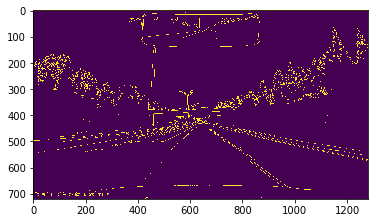

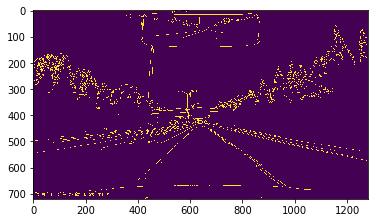

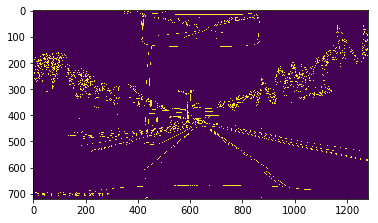

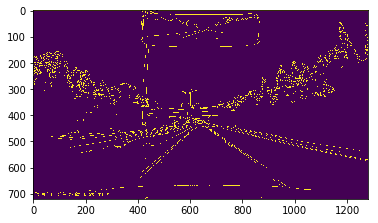

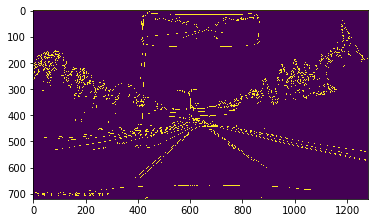

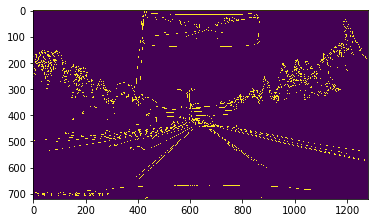

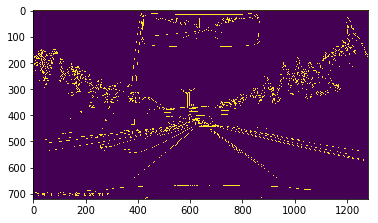

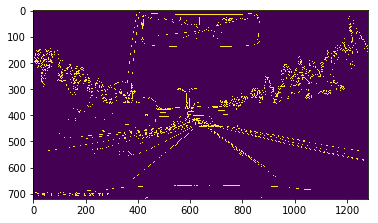

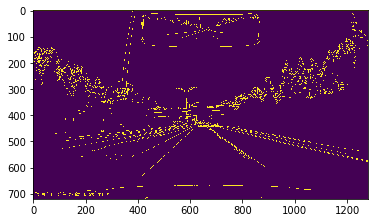

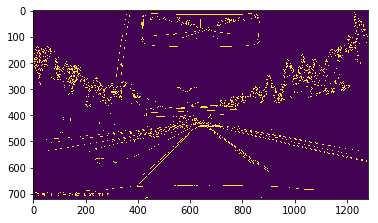

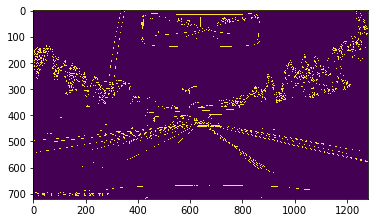

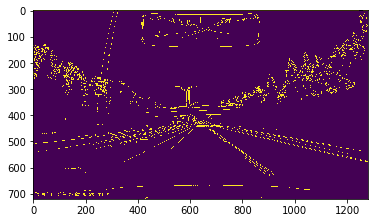

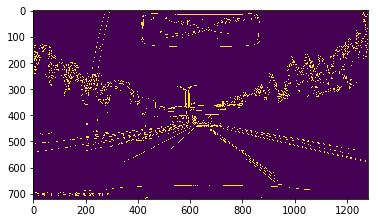

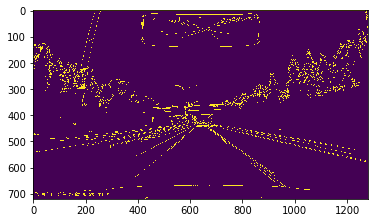

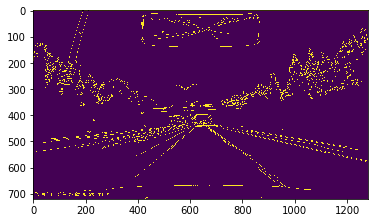

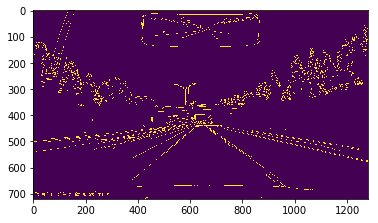

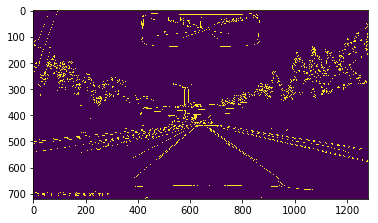

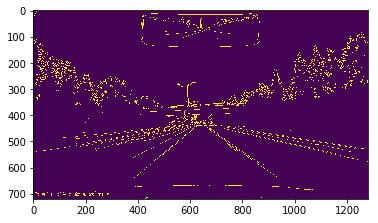

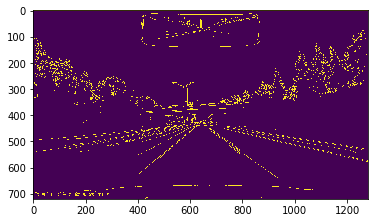

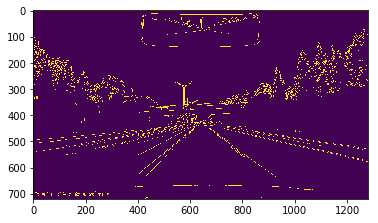

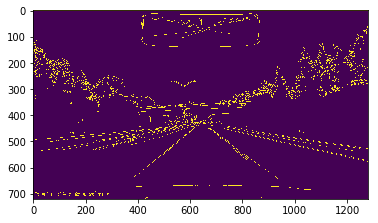

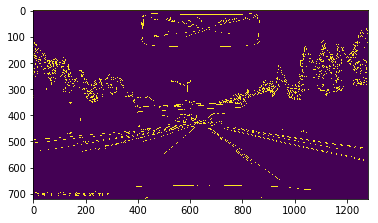

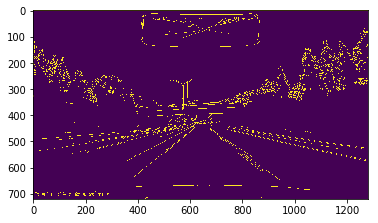

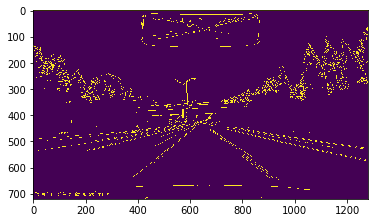

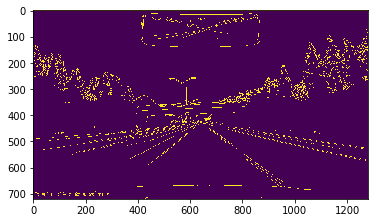

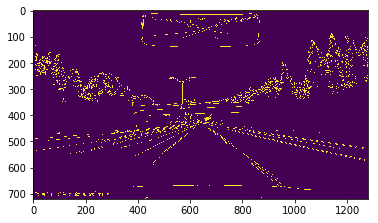

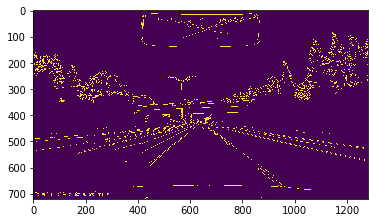

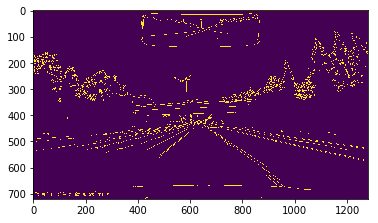

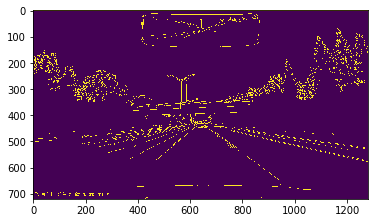

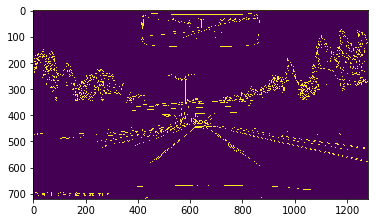

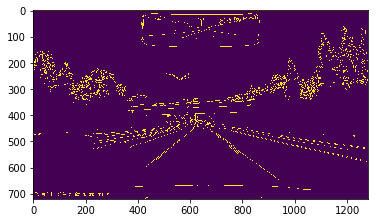

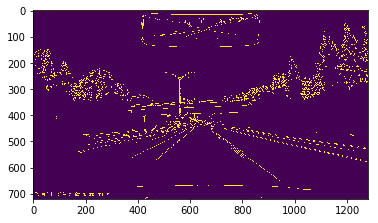

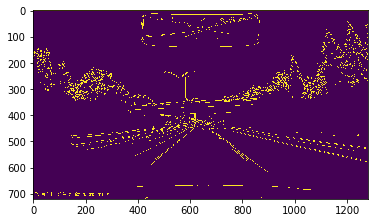

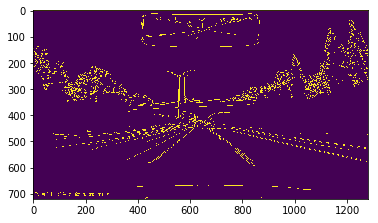

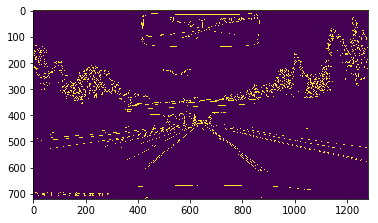

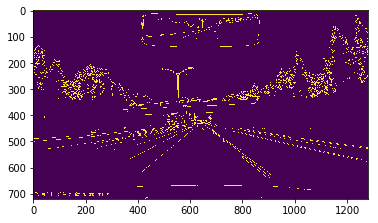

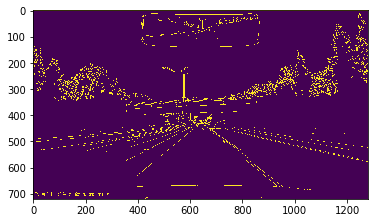

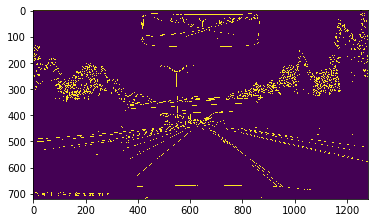

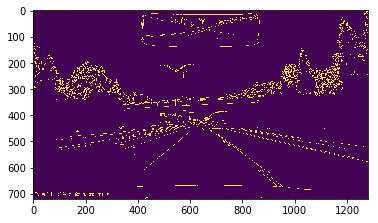

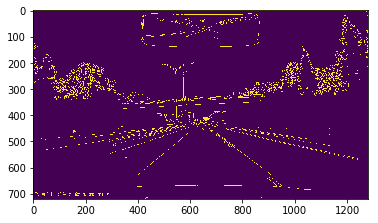

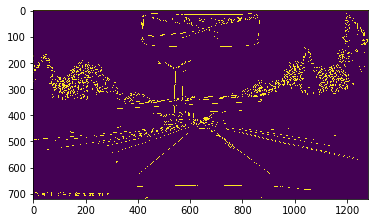

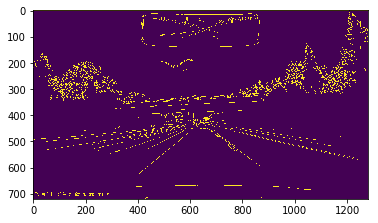

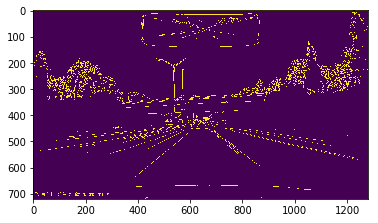

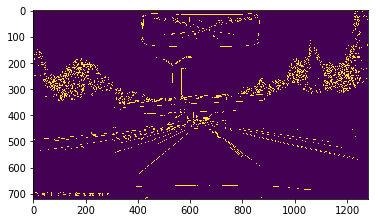

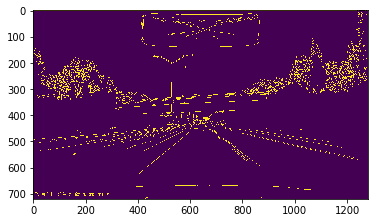

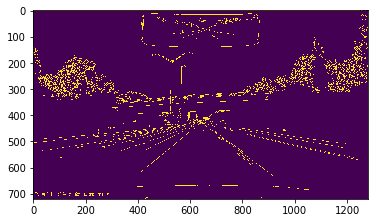

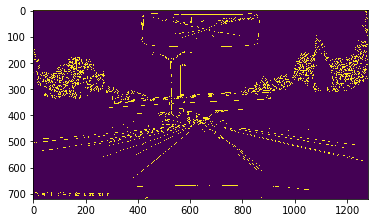

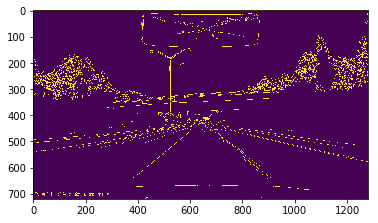

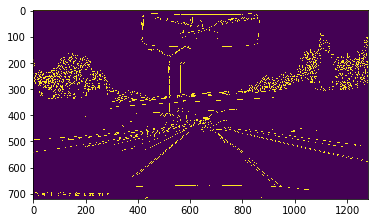

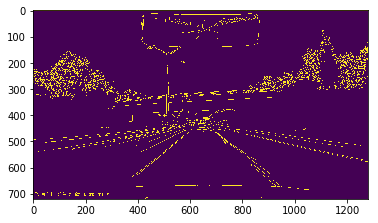

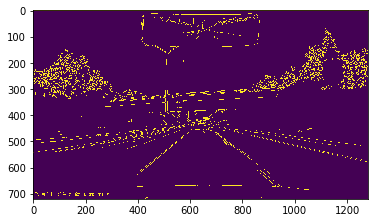

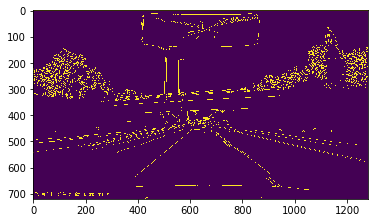

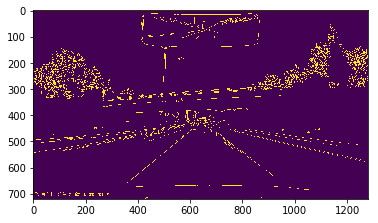

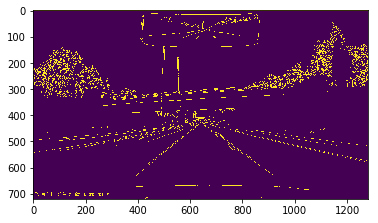

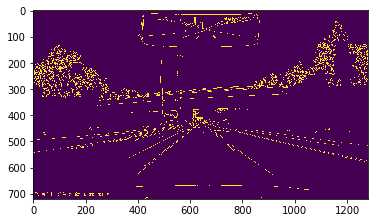

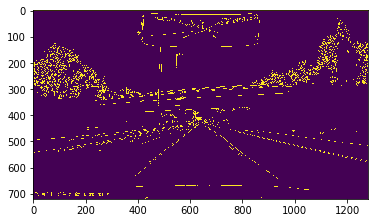

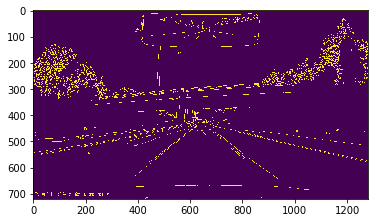

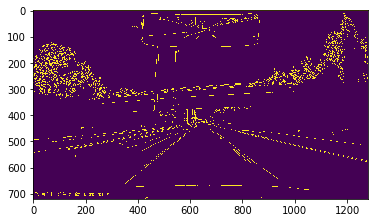

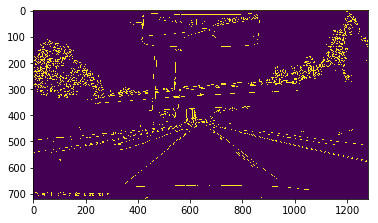

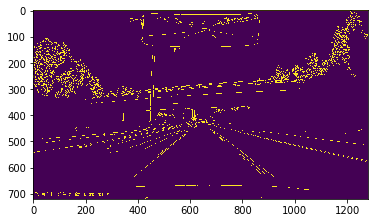

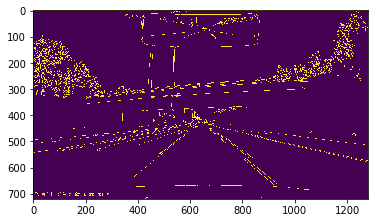

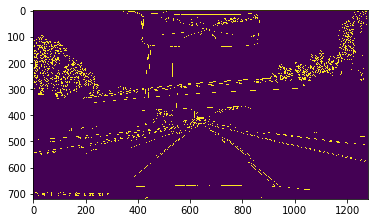

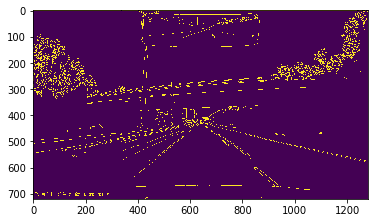

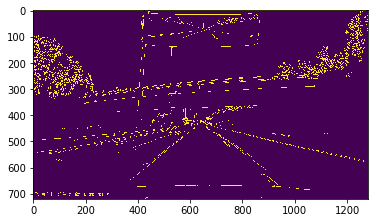

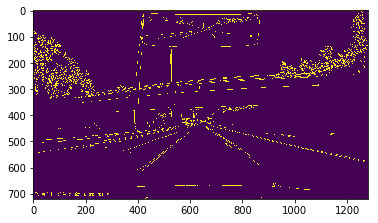

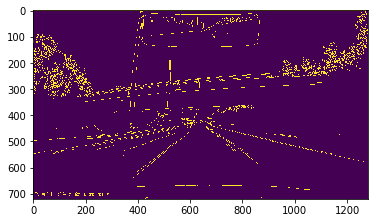

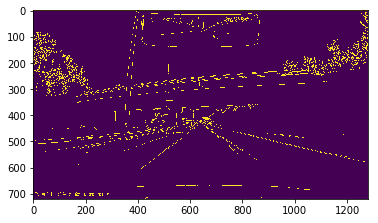

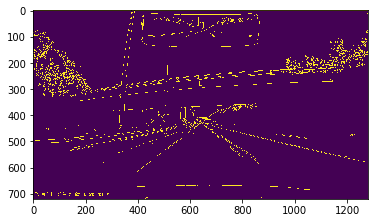

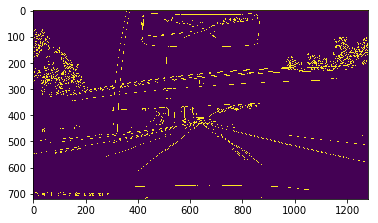

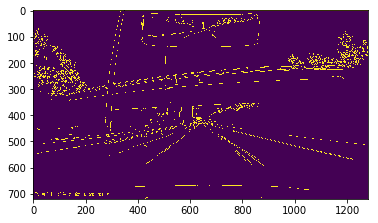

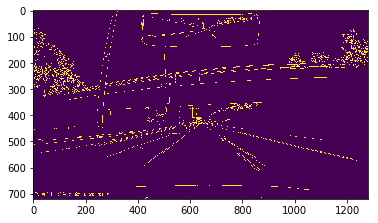

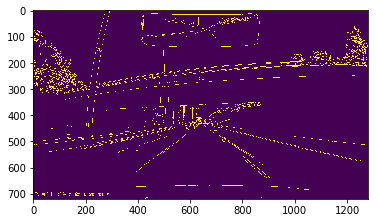

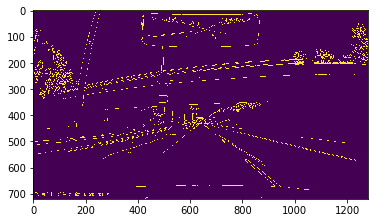

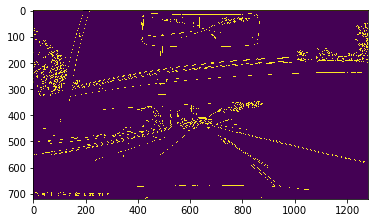

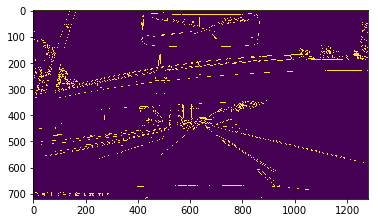

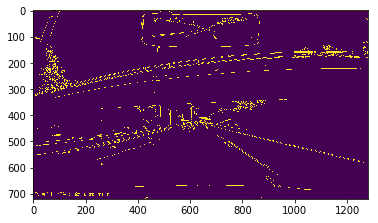

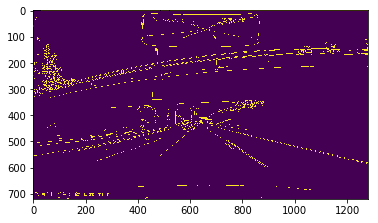

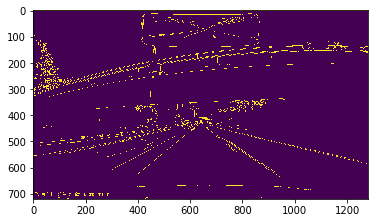

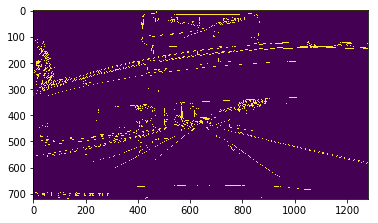

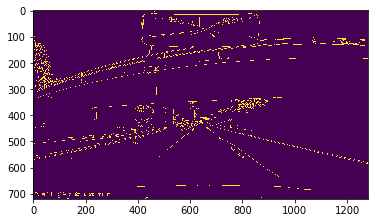

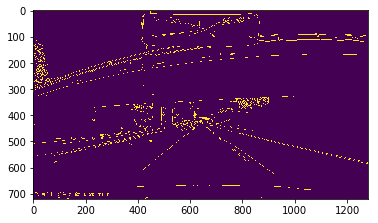

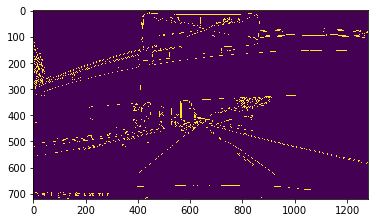

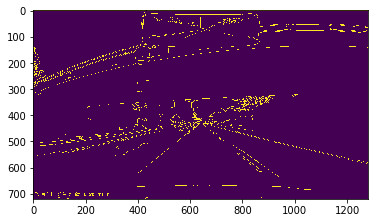

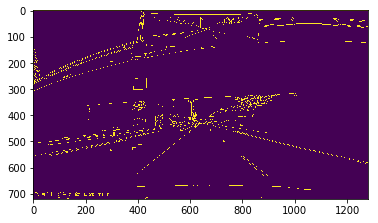

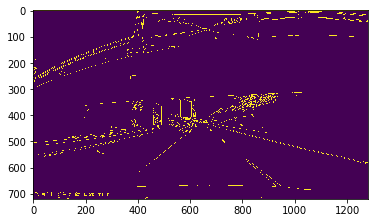

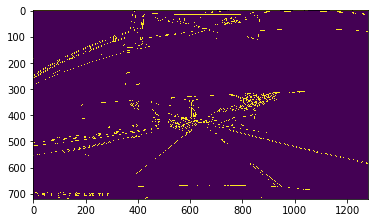

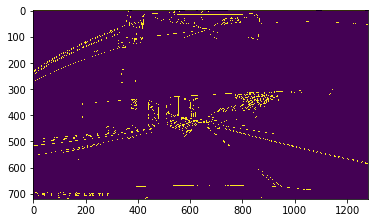

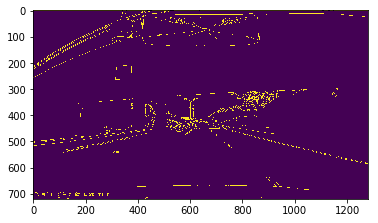

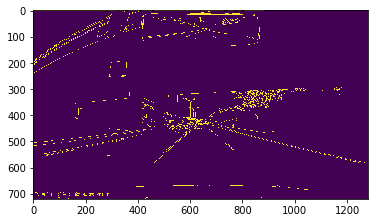

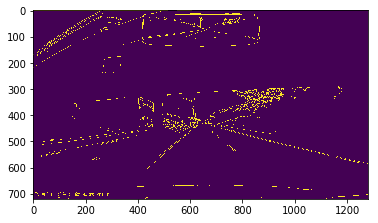

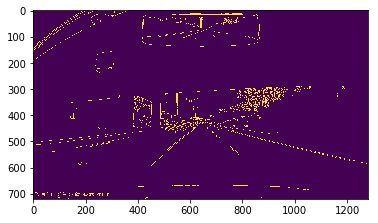

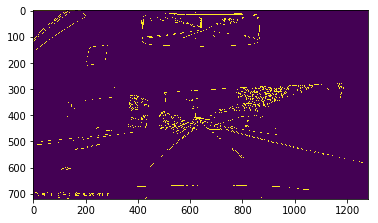

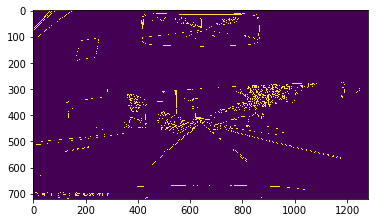

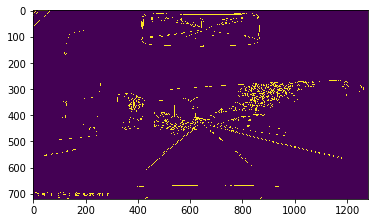

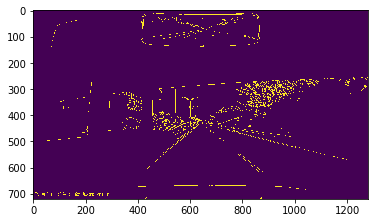

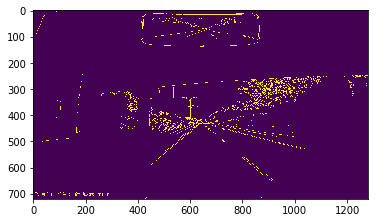

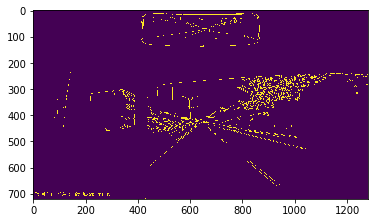

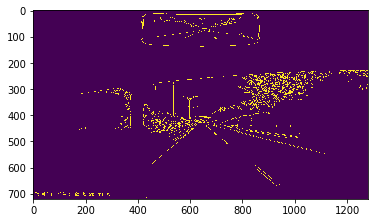

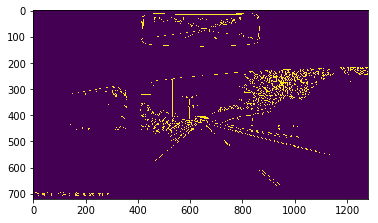

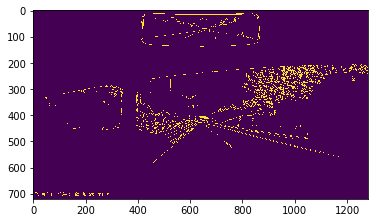

TypeError: 'numpy.float64' object is not iterable

In [1]:
import cv2
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt

%matplotlib inline

prev_left = 0

def make_points(image, line):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        slope, intercept = line
        y1 = int(image.shape[0])# bottom of the image
        y2 = int(y1*3/5)         # slightly lower than the middle
        x1 = int((y1 - intercept)/slope)
        x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]
 
def average_slope_intercept(image, lines):
    global prev_left
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        left_fit    = []
        right_fit   = []
        if lines is None:
            return None
        for line in lines:
            for x1, y1, x2, y2 in line:
                fit = np.polyfit((x1,x2), (y1,y2), 1)
                slope = fit[0]
                intercept = fit[1]
                if slope < 0: # y is reversed in image
                    left_fit.append((slope, intercept))
                else:
                    right_fit.append((slope, intercept))
        # add more weight to longer lines
        if len(left_fit) == 0:
            left_fit_average = prev_left
        else:
            left_fit_average = np.average(left_fit, axis=0)
        right_fit_average = np.average(right_fit, axis=0)
        left_line  = make_points(image, left_fit_average)
        right_line = make_points(image, right_fit_average)
        averaged_lines = [left_line, right_line]
        prev_left = left_fit_average
    return averaged_lines
 
def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5, 5),0)
    canny = cv2.Canny(blur, 50, 150)
    return canny
 
def display_lines(img,lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image
 
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
 
#     triangle = np.array([[
#     (200, height),
#     (550, 250),
#     (1100, height),]], np.int32)

    # For Toronto webcam
    triangle = np.array([[
    (250, height-60),
    (650, 400),
    (1100, height-60),]])
    
    # test 7
#     triangle = np.array([[
#     (50, height),
#     (600, 400),
#     (850, height),]])
 
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image

def hough_lines(img):
    lines = cv2.HoughLinesP(img, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
    return lines
 
# Video Example 
cap = cv2.VideoCapture("Test_5.mp4")
success, frame = cap.read()
while success:
    success, frame = cap.read()
    if not success:
        break
    canny_image = canny(frame)
    plt.imshow(canny_image)
    plt.show()
    cropped_canny = region_of_interest(canny_image)
    lines = hough_lines(cropped_canny)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.imshow("result", combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()